# AVITO PROJECT

## Team Member

* Sandikha Rahardi - РИМ 130908

## Load Data

### Import Package

In [1642]:

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Set Dataframe

In [1643]:
dataset_filename = "assets/avito_dataset.xlsx"
main_df = pd.read_excel(dataset_filename, sheet_name="Sheet1")

## Data Cleaning

### Important Column

In [1644]:
# Define important column to predict the price
important_columns = [
    'Цена', 'Метро', 'Метро2', 'Метро. Время', 
    'Район', 'Продавец. Компания', 'Статус', 'Количество комнат',
    'Общая площадь, число', 'Этаж', 'Санузел', 
    'Балкон или лоджия', 'Окна', 'Ремонт', 
    'Тип дома', 'Этажей в доме', 'Площадь кухни, число'
]
print("Total original column : " , main_df.columns.__len__())
print("Total important column : " , important_columns.__len__())
main_df = main_df[important_columns]

Total original column :  71
Total important column :  17


In [1645]:
print(main_df.shape)
main_df.isnull().sum() / main_df.shape[0] * 100

(19803, 17)


Цена                     0.000000
Метро                    0.489825
Метро2                  47.856385
Метро. Время            47.856385
Район                   52.310256
Продавец. Компания       0.000000
Статус                   0.000000
Количество комнат        0.000000
Общая площадь, число     0.000000
Этаж                     0.000000
Санузел                 40.301974
Балкон или лоджия       32.692016
Окна                    56.824724
Ремонт                  60.793819
Тип дома                13.750442
Этажей в доме            0.000000
Площадь кухни, число    19.491996
dtype: float64

### Clean the dataset

#### Remove duplicated dataset

In [1646]:
print("Duplicated data : ", main_df.duplicated().sum())
main_df = main_df.drop_duplicates().reset_index(drop=True)
print("Duplicated data (now) : ", main_df.duplicated().sum())

Duplicated data :  276
Duplicated data (now) :  0


#### Clean about 'Метро'

In [1647]:
main_df.dropna(subset=['Метро'], inplace=True)

def preprocess_metro_time(row):
    if(type(row) == str):
        row = row.replace("мин.","").strip()
        if(row.__contains__("от")):
            row = float(row.replace("от","").strip())
        elif(row.__contains__("до")):
            row = float(row.replace("до","").strip())
        elif(row.__contains__("–")):
            row = (int(row.split("–")[0]) + int(row.split("–")[1])) / 2
    return row

main_df['Метро. Время'] = main_df['Метро. Время'].apply(preprocess_metro_time)
mean_metro_time = round(pd.to_numeric(main_df['Метро. Время']).mean(), 1)
main_df['Метро. Время'].fillna(mean_metro_time, inplace=True)
main_df['Метро2'] = main_df['Метро2'].apply(lambda x: 0 if pd.isna(x) else 1)

#### Clean about 'Район'

In [1648]:
main_df['Район'].fillna("Другой", inplace=True)

#### Clean about 'Продавец. Компания'

In [1649]:
main_df['Продавец. Компания'] = main_df['Продавец. Компания'].apply(lambda x: 0 if str(x) == "Нет" else 1)

#### Clean about 'Количество комнат'

In [1650]:
main_df['Количество комнат'] = main_df['Количество комнат'].apply(lambda x: 0 if x == 'Студия' else x)

max_room = pd.to_numeric(main_df['Количество комнат'], errors='coerce').max()
mean_room = pd.to_numeric(main_df['Количество комнат'], errors='coerce').mean()

main_df['Количество комнат'] = main_df['Количество комнат'].apply(lambda x: max_room if x == 'многокомнатные' else x)
main_df['Количество комнат'] = main_df['Количество комнат'].apply(lambda x: round(mean_room) if x == 'Своб. планировка' else x)

> Note: Студия does not have room ( 0 room )

#### Clean about 'Общая площадь, число'

In [1651]:
main_df['Общая площадь, число'] = main_df['Общая площадь, число'].apply(lambda x: float(x.replace(",", ".")) if type(x) == str else float(x))

#### Clean about 'Этаж'

In [1652]:
# Clean dataset 'Этаж' of 'Этажей в доме'
main_df['Этаж'] = main_df['Этаж'].apply(lambda x: int(x.split("из")[0].strip()))

#### Clean about 'Санузел'

In [1653]:
main_df['Санузел'].fillna('Другой', inplace=True)

#### Clean about 'Балкон или лоджия'

In [1654]:
main_df['Балкон или лоджия'].fillna('Другой', inplace=True)

#### Clean about 'Окна'

In [1655]:
main_df['Окна'].fillna('Другой', inplace=True)

#### Clean about 'Ремонт'

In [1656]:
main_df['Ремонт'].fillna('Другой', inplace=True)

#### Clean about 'Тип дома'

In [1657]:
main_df['Тип дома'].fillna('Другой', inplace=True)

#### Clean about 'Площадь кухни, число'

In [1658]:
main_df['Площадь кухни, число'] = main_df['Площадь кухни, число'].apply(lambda x: float(x.replace(",", ".")) if type(x) == str else float(x))
main_df['Площадь кухни, число'].fillna(main_df['Площадь кухни, число'].mode()[0], inplace=True)

### Dummies Variables

In [1659]:
preprocessing_categorical_columns = ['Метро', 'Район', 'Статус', 'Санузел', 'Балкон или лоджия', 'Окна', 'Ремонт', 'Тип дома']
main_df[preprocessing_categorical_columns].head()

,Метро,Район,Статус,Санузел,Балкон или лоджия,Окна,Ремонт,Тип дома
0,м. р-н Академический,Академический,Квартира,Раздельный,Лоджия,Другой,Косметический,Монолитный
1,м. Геологическая,Другой,Квартира,Совмещённый,Балкон,"На улицу, На солнечную сторону",Косметический,Панельный
2,м. Уральская,Другой,Квартира,Раздельный,Балкон,Во двор,Евро,Монолитный
3,м. р-н Академический,Академический,Квартира,Совмещённый,Балкон,"Во двор, На улицу",Другой,Монолитный
4,м. р-н Академический,Академический,Квартира,Совмещённый,Балкон,"Во двор, На улицу",Другой,Монолитный


In [1660]:
preprocessing_categorical_columns = ['Метро', 'Район', 'Статус', 'Санузел', 'Балкон или лоджия', 'Окна', 'Ремонт', 'Тип дома']
all_dummies_variable = []
dict_dummies_variable = dict()

for cat_column in preprocessing_categorical_columns:
    all_data = []
    dummies_df = main_df[cat_column].value_counts().reset_index()[cat_column]
    
    for index_data in range(len(dummies_df)):
        data = dict()
        data["dummies"] = index_data
        data["value"] = dummies_df[index_data]
        all_data.append(data)
        main_df[cat_column] = main_df[cat_column].apply(lambda x: index_data if x == dummies_df[index_data] else x)
    
    dict_dummies_variable[cat_column] = all_data
    all_dummies_variable.append(dict_dummies_variable)
    
main_df[preprocessing_categorical_columns].head()

,Метро,Район,Статус,Санузел,Балкон или лоджия,Окна,Ремонт,Тип дома
0,0,1,0,2,0,0,1,0
1,4,0,0,1,2,6,1,3
2,5,0,0,2,2,1,2,0
3,0,1,0,1,2,2,0,0
4,0,1,0,1,2,2,0,0


### Clean Outliers

Text(0.5, 1.0, 'Цена')

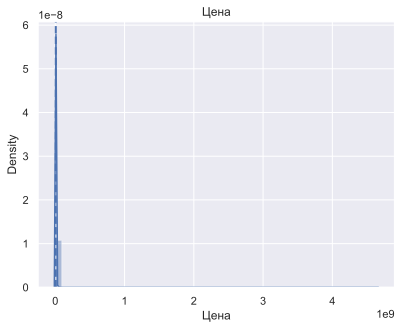

In [1661]:
sns.distplot(main_df['Цена'])
plt.axvline(x=main_df['Цена'].mean(), linestyle='--', linewidth=2)
plt.title('Цена')

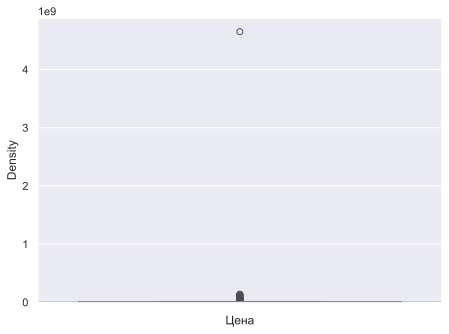

In [1662]:
sns.distplot(main_df['Цена'])
plt1 = sns.boxplot(main_df['Цена'])
plt.tight_layout()

In [1663]:
print("BEFORE : ", main_df.shape)

column_to_check = 'Цена'
Q1 = main_df[column_to_check].quantile(0.25)
Q3 = main_df[column_to_check].quantile(0.75)
IQR = Q3 - Q1

main_df = main_df[~((main_df[column_to_check] < (Q1 - 1.5 * IQR)) | (main_df[column_to_check] > (Q3 + 1.5 * IQR)))]

print("AFTER : ", main_df.shape)

BEFORE :  (19430, 17)
AFTER :  (18381, 17)


Text(0.5, 1.0, 'Цена')

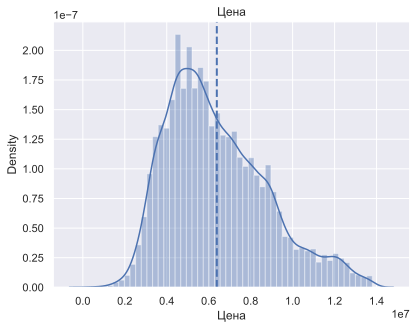

In [1664]:
sns.distplot(main_df['Цена'])
plt.axvline(x=main_df['Цена'].mean(), linestyle='--', linewidth=2)
plt.title('Цена')

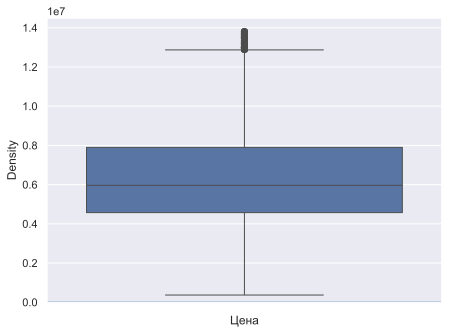

In [1665]:
sns.distplot(main_df['Цена'])
plt1 = sns.boxplot(main_df['Цена'])
plt.tight_layout()

## Pre-Processing Dataset

### Split Dataset

In [1666]:
# Split the data into training (80%), testing (15%), and validation (5%)
train_df, test_df = train_test_split(main_df, test_size=0.2, random_state=42)
print(train_df.shape)
print(test_df.shape)

(14704, 17)
(3677, 17)


### Divided into Categorical and Numerical dataset

In [1667]:
label = 'Цена'
numerical_columns = ['Метро. Время', 'Количество комнат', 'Общая площадь, число', 'Этаж', 'Этажей в доме', 'Площадь кухни, число']
categorical_columns = ['Метро', 'Метро2', 'Район', 'Продавец. Компания', 'Статус', 'Санузел', 'Балкон или лоджия', 'Окна', 'Ремонт', 'Тип дома']

train_num_df = train_df[numerical_columns]
train_cat_df = train_df[categorical_columns]
test_num_df = test_df[numerical_columns]
test_cat_df = test_df[categorical_columns]

### Split X and Y dataset

In [1668]:
X_train = train_df.drop('Цена', axis=1)
y_train = train_df[label]
X_test = test_df.drop('Цена', axis=1)
y_test = test_df[label]

### Visualization Correlation

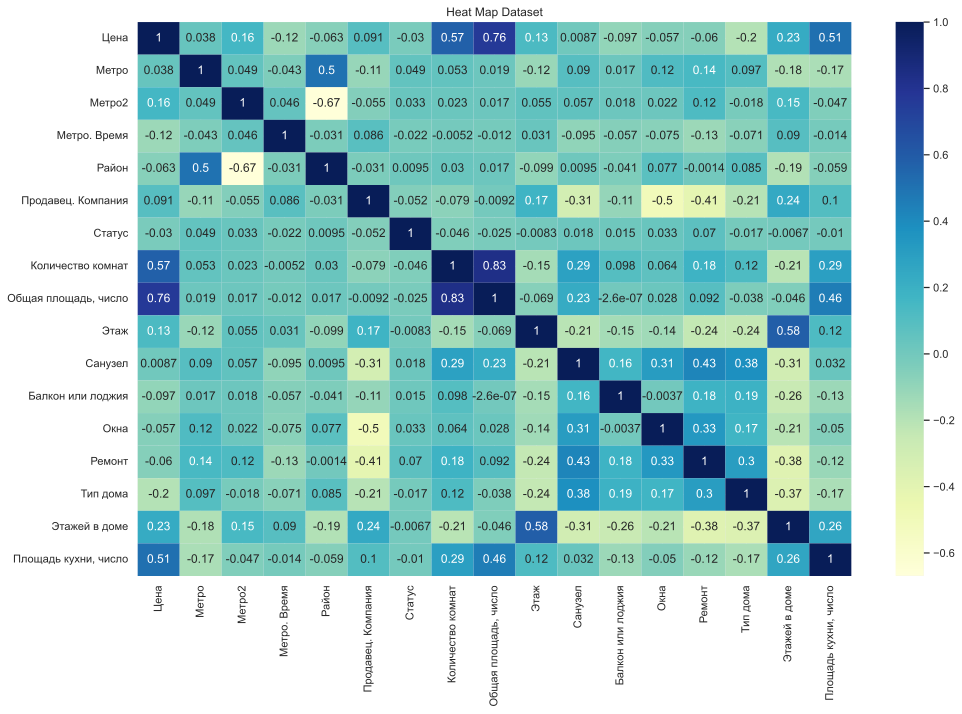

In [1669]:
plt.figure(figsize = (16, 10))
plt.title("Heat Map Dataset")
sns.heatmap(main_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

## Model Building

### Dictionary Models

In [1670]:
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor()
}

model_results = []
model_names = []

In [1671]:
for name,model in models.items():
    model_fit = model.fit(X_train,y_train)
    
    olsWrapper = sm.OLS(y_train,X_train).fit()
    print(f"\n## MODEL ==> {name}\n")
    print(olsWrapper.summary())
    
    y_predicted = model_fit.predict(X_test)
    score = np.sqrt(mse(y_test, y_predicted))
    model_results.append(score)
    model_names.append(name)
    
    df_results = pd.DataFrame([model_names,model_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE'}).sort_values(by='RMSE',ascending=False)


## MODEL ==> SVR

                                 OLS Regression Results                                
Dep. Variable:                   Цена   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          2.437e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):                        0.00
Time:                        11:33:09   Log-Likelihood:                     -2.2788e+05
No. Observations:               14704   AIC:                                  4.558e+05
Df Residuals:                   14688   BIC:                                  4.559e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
------------

In [1672]:
df_results

,Model,RMSE
4,SGDRegressor,4793834.740306
0,SVR,2404922.342989
3,ElasticNet,1257998.143454
5,BayesianRidge,1233088.359498
2,Ridge,1232623.102726
6,LinearRegression,1232601.079055
7,RandomForestRegressor,702329.051538
1,XGBRegressor,646095.286584


#### Optimal Regressor (XGB)

In [1673]:
best_params = {'lambda': 3.559040735218393,
 'alpha': 0.25772549522868987,
 'colsample_bytree': 0.6,
 'subsample': 0.5,
 'learning_rate': 0.014,
 'n_estimators': 4000,
 'max_depth': 11,
 'random_state': 24,
 'min_child_weight': 3}

reg_XGBR = XGBRegressor(**best_params)

reg_XGBR.fit(X_train, y_train)
predicted = reg_XGBR.predict(X_test)
print(f'Root Mean Square Error test = {mse(y_test, predicted,squared=False)}')

Root Mean Square Error test = 604824.1112606539


## Model Evaluation

In [1674]:
res = (predicted - y_test)

Text(0.5, 0, 'Errors')

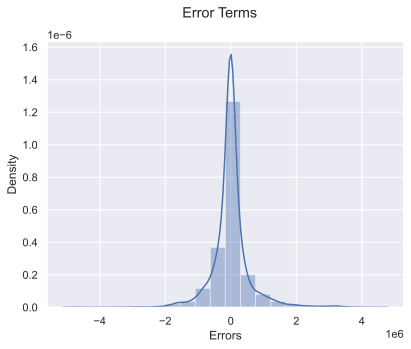

In [1675]:
fig = plt.figure()
sns.distplot((y_test - predicted), bins = 20)
fig.suptitle('Error Terms')
plt.xlabel('Errors')                   

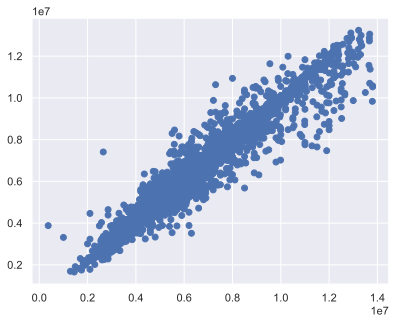

In [1676]:
plt.scatter(y_test,predicted)
plt.show()

In [1677]:
r2(y_test, predicted)

0.9350885194836289

Text(0, 0.5, 'predicted')

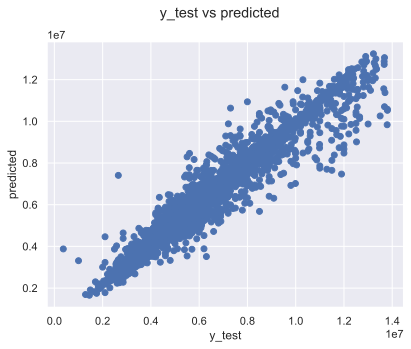

In [1678]:
fig = plt.figure()
plt.scatter(y_test,predicted)
fig.suptitle('y_test vs predicted')
plt.xlabel('y_test')
plt.ylabel('predicted')        

## Scoring Model Error

In [1679]:
# Mean Absolute Error
mae = mae(y_test, predicted)
print("Mean Absolute Error: ", mae)

# Mean Squared Error
mse = mse(y_test, predicted)
print("Mean Squared Error: ", mse)

# Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

# R-squared (R2) Score
r2_score = r2(y_test, predicted)
print("R-squared (R2) Score: ", r2_score)

Mean Absolute Error:  343801.8266929562
Mean Squared Error:  365812205562.23987
Root Mean Squared Error:  604824.1112606539
R-squared (R2) Score:  0.9350885194836289
